In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import gc
gc.enable()
import os
print(os.listdir("../input"))

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import Lasso, Ridge
from scipy.signal import argrelextrema, stft, find_peaks
from numpy.fft import fft
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE
import seaborn as sns
import csv
from multiprocessing import Pool
from tqdm import tqdm

TRAIN_PATH = "../input/train.csv"

['test', 'train.csv', 'sample_submission.csv']


In [3]:
subset_size = 629145481
# subset_size = 100147179
# subset_size = 18227196

In [4]:
def get_chunks(chunk_count):
    assert(subset_size>=chunk_count)
    chunk_size = int(subset_size/chunk_count)
    res = [[1+i*chunk_size, 1+(i+1)*chunk_size, i] for i in range(chunk_count)]
    res[-1][1] = subset_size + 1
    return res
def read_section(rng):
    return (rng[2], pd.read_csv(TRAIN_PATH, nrows=rng[1]-rng[0], skiprows=rng[0], 
                    names=['acoustic_data','time_to_failure'],
                    dtype={'acoustic_data': np.int16
                           , 'time_to_failure': np.float64
                              }))
def load_data():
    res = []
    with Pool(8) as p:
        import sys
        split_work_to = 8
        for i, r in enumerate(p.imap_unordered(read_section, get_chunks(split_work_to)), 1):
            res.append(r)
            sys.stderr.write('\rdone {0}'.format(i*100/split_work_to))
    res.sort(key=lambda x: x[0])
    x = np.concatenate(list(map(lambda x: x[1]["acoustic_data"].values, res)), axis=None)
    y = np.concatenate(list(map(lambda x: x[1]["time_to_failure"].values, res)), axis=None)
    return x,y

def split_to_4096(x,y):
    def fix_4096(x):
        if len(x) < 4094 or len(x) > 4096:
            raise Exception(f'length of segment too big {len(x)}')
        else:
            while len(x) < 4096:
                x = np.append(x,x[-1])
        return x
    
    df = np.diff(y)
    split_indices = np.argwhere(np.logical_or(df>0.0001, df<-0.0001)).reshape(-1) + 1
    y = np.append(y[split_indices - 1], y[-1])
    x = np.array(list(map(fix_4096, np.split(x, split_indices))))
    return x, y
def split_to_expiriments(x,y):
    quake_point = np.array(argrelextrema(y, np.less, order=2)[0]) + 1 # get split indexes by quake times
    return [(x,y) for x,y in zip(np.split(x, quake_point, axis=0), np.split(y,quake_point,axis=0))]
x_all, y_all = load_data()
exps = split_to_expiriments(x_all, y_all)

done 100.0

In [5]:
def preprocess(x,y=None,is_test=False):
    window_size = 150000*4
    if is_test:
        window_size = 150000
    rol_general = pd.DataFrame(data=x).rolling(window_size)
    rol = pd.DataFrame(data=x).rolling(50)
    res = pd.DataFrame()
    res['min'] = rol_general.min()[0]
    res['max'] = rol_general.max()[0]
    res['min-max'] = res['min'].values - res['max'].values
    res['std'] = rol_general.std()[0]
    res['median'] = rol_general.median()[0]
    res['var'] = rol_general.var()[0]
    res['kurt'] = rol_general.kurt()[0]
    res['skew'] = rol_general.skew()[0]
    std_rol = rol.std().rolling(window_size,min_periods=1)
    res['std_50_min'] = std_rol.min()[0]
    res['std_50_max'] = std_rol.max()[0]
    res['std_50_std'] = std_rol.std()[0]
    
    res = res.iloc[window_size-1:,:]
    if y is None:
        return res
    return res, y[window_size-1:]
exps_data = [preprocess(x,y) for x,y in exps]

train: 0.17586789244447842 test: 373.7936905433126


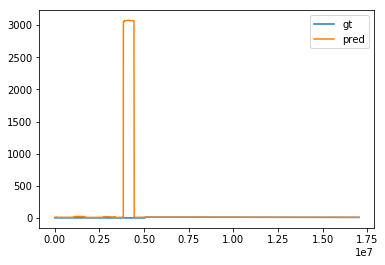

train: 0.14170408072930366 test: 9.039543495058606


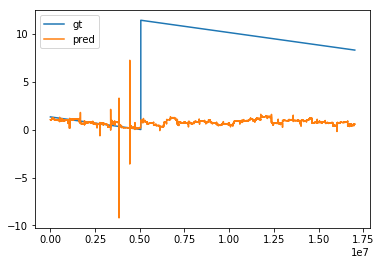

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [6]:
all_x = pd.concat([exps_data[i][0] for i in range(len(exps_data))], axis = 0)
all_y = np.concatenate([exps_data[i][1] for i in range(len(exps_data))], axis = 0)
model = Ridge(alpha=.5)
for k in range(len(exps_data)):
    train_x = pd.concat([exps_data[i][0] for i in range(len(exps_data)) if i != k], axis = 0)
    train_y = np.concatenate([exps_data[i][1] for i in range(len(exps_data)) if i != k], axis = 0)
    model.fit(train_x, train_y)
    y_pred_train = model.predict(train_x)
    y_pred_test = model.predict(exps_data[k][0])
    print("train:", MAE(train_y, y_pred_train), "test:" ,MAE(exps_data[k][1], y_pred_test))
    plt.plot(all_y, label="gt")
    plt.plot(model.predict(all_x), label="pred")
    plt.legend()
    plt.show()

model.fit(all_x, all_y)

In [8]:
subm = pd.read_csv('../input/sample_submission.csv')
def pred(fn):
    print(fn)
    test = pd.read_csv(f"../input/test/{fn}.csv",
                    dtype={'acoustic_data': np.int16})
    test = np.array(test)
    test = preprocess(test, is_test=True)
    return model.predict(test)[0]
subm['time_to_failure'] = [pred(x) for x in subm['seg_id'].values]
subm_with_zero = subm
max_with_0 = subm['time_to_failure'].values
max_with_0[max_with_0<0]=0
subm['time_to_failure']=max_with_0
subm.to_csv("submission.csv", index=False)

seg_00030f
seg_0012b5
seg_00184e
seg_003339
seg_0042cc
seg_004314
seg_004cd2
seg_004ee5
seg_004f1f
seg_00648a
seg_006e4a
seg_007a37
seg_00a37e
seg_00be11
seg_00c35b
seg_00cc91
seg_00e5f7
seg_00f3b9
seg_010eab
seg_0125d9
seg_0144cb
seg_0165c6
seg_016913
seg_016cdb
seg_017314
seg_01a8dc
seg_01c775
seg_01ecb0
seg_02042f
seg_025e78
seg_032822
seg_0339ca
seg_037461
seg_038879
seg_03d386
seg_03d63e
seg_03d680
seg_03f380
seg_0445d7
seg_046c28
seg_0488a1
seg_049957
seg_04a696
seg_04ae38
seg_04b87a
seg_04cceb
seg_04ee93
seg_04fd93
seg_0536c9
seg_055127
seg_05a1b0
seg_05a4ad
seg_05b66a
seg_05bef4
seg_05e0d7
seg_05f126
seg_05f9d6
seg_060ce4
seg_061a33
seg_0620e6
seg_063865
seg_065588
seg_06893f
seg_06b8c9
seg_06bbc5
seg_06d4a2
seg_06d7ba
seg_070bb0
seg_071067
seg_073696
seg_075340
seg_075f77
seg_0775a7
seg_077b7e
seg_079e34
seg_07c815
seg_07cd72
seg_07f37c
seg_07f8df
seg_07fc6d
seg_086a61
seg_0870ab
seg_0879a8
seg_08b136
seg_08f441
seg_08fd5b
seg_091c9d
seg_093a0a
seg_0968f1
seg_0981f3
seg_09dd59

seg_4c12b2
seg_4c18e2
seg_4c3a2b
seg_4c4995
seg_4c65e6
seg_4c8db6
seg_4ca6de
seg_4cb0d7
seg_4cb9c6
seg_4ce234
seg_4d0008
seg_4d0041
seg_4d0c45
seg_4d18f4
seg_4d2671
seg_4d53c2
seg_4d5a4a
seg_4d7c56
seg_4d8f0f
seg_4db886
seg_4db997
seg_4dbbd1
seg_4ddddc
seg_4dfa03
seg_4e0c4a
seg_4e2c66
seg_4e3bd7
seg_4e627b
seg_4e9646
seg_4ea3fa
seg_4ea81c
seg_4eb127
seg_4eeaef
seg_4eef28
seg_4f48b4
seg_4f5931
seg_4f76a2
seg_4f83a3
seg_4fa87d
seg_4fce5b
seg_4fd191
seg_500108
seg_5009d9
seg_500c80
seg_502fab
seg_507065
seg_5090fa
seg_509d55
seg_50a667
seg_50b048
seg_50e270
seg_511d25
seg_512b3e
seg_514543
seg_5147e1
seg_514b85
seg_5165a4
seg_517345
seg_517425
seg_51865e
seg_518b1e
seg_51b68c
seg_51f0a2
seg_51f6fd
seg_521a88
seg_523945
seg_524b39
seg_5254ce
seg_5255c0
seg_52636c
seg_529be4
seg_529c99
seg_52c139
seg_530a02
seg_53103b
seg_5311d1
seg_533613
seg_53498a
seg_53a557
seg_53a5fd
seg_53bdf5
seg_53caf1
seg_53d818
seg_53e645
seg_53fa13
seg_5407b0
seg_5445bc
seg_54490e
seg_545fda
seg_5467c8
seg_546864

seg_957ece
seg_95b321
seg_95f45e
seg_961d02
seg_961ddf
seg_9626a4
seg_96642e
seg_966f3d
seg_967ae4
seg_96cd5d
seg_96dab2
seg_96db5e
seg_96fa35
seg_970b35
seg_970e86
seg_974049
seg_9757ac
seg_979a8f
seg_97a161
seg_97ad82
seg_97d9ed
seg_97e4a9
seg_9802c3
seg_9825e0
seg_983778
seg_986976
seg_986b6e
seg_9872f9
seg_988e69
seg_98a819
seg_98be13
seg_98c0b6
seg_98c44d
seg_98c544
seg_98ebaa
seg_98f624
seg_9940e8
seg_996c37
seg_99ccbd
seg_99f677
seg_99f76c
seg_9a1a4f
seg_9a1c76
seg_9a43ef
seg_9a6025
seg_9a74d8
seg_9a7c46
seg_9a7d1d
seg_9a812d
seg_9a81a3
seg_9a8a1f
seg_9a9041
seg_9a92db
seg_9aa6e2
seg_9ab405
seg_9ad261
seg_9ad925
seg_9ae1a1
seg_9b0439
seg_9b44d2
seg_9b7ef8
seg_9b7f93
seg_9bab11
seg_9bd388
seg_9bee43
seg_9c00d7
seg_9c090f
seg_9c2843
seg_9c3d6a
seg_9c3ef8
seg_9c635d
seg_9c6715
seg_9c8162
seg_9c8bc8
seg_9ca72e
seg_9caf50
seg_9cb464
seg_9d1b26
seg_9d1dbe
seg_9d2528
seg_9d3013
seg_9d452d
seg_9d57a1
seg_9d68cf
seg_9d6ff0
seg_9d7490
seg_9d79d4
seg_9dcae1
seg_9ddc99
seg_9dea8d
seg_9df32d

seg_da80c4
seg_da8b88
seg_dab0f9
seg_dad4f2
seg_db3446
seg_db3a95
seg_db3fbe
seg_db4185
seg_db606c
seg_db694a
seg_db6d5f
seg_db90c0
seg_dbbb44
seg_dbc615
seg_dbf3f2
seg_dc188b
seg_dc1cf0
seg_dc23c0
seg_dc4698
seg_dc5e63
seg_dc6e94
seg_dc73b8
seg_dc7e0d
seg_dca2c2
seg_dcb51d
seg_dcbe02
seg_dcd9df
seg_dcee28
seg_dceeca
seg_dcf242
seg_dcfb4b
seg_dd0b11
seg_dd4594
seg_dd699c
seg_dd780d
seg_dd8805
seg_ddbadc
seg_ddc800
seg_ddd206
seg_ddddf0
seg_de225c
seg_de3237
seg_de3d5e
seg_de4e1d
seg_de8180
seg_de98fa
seg_de9e32
seg_df0df7
seg_df352f
seg_df45b0
seg_df8385
seg_df8e0a
seg_df99d4
seg_dff078
seg_e00465
seg_e051bc
seg_e05de2
seg_e067ab
seg_e09301
seg_e0c329
seg_e0ce38
seg_e0cfd4
seg_e0f296
seg_e10d3b
seg_e13bd8
seg_e14149
seg_e1468f
seg_e15cb9
seg_e197b8
seg_e1a9e0
seg_e1daa0
seg_e1f045
seg_e1f081
seg_e20d76
seg_e217fc
seg_e2209b
seg_e24496
seg_e24f69
seg_e256bd
seg_e25aca
seg_e266f4
seg_e27c0a
seg_e29670
seg_e2b8b1
seg_e2c82c
seg_e3005e
seg_e30e44
seg_e30ef5
seg_e34052
seg_e37b8e
seg_e3b1f1

In [9]:
subm

,seg_id,time_to_failure
0,seg_00030f,1.464173
1,seg_0012b5,2.717953
2,seg_00184e,5.873728
3,seg_003339,9.186204
4,seg_0042cc,4.859138
5,seg_004314,0.000000
6,seg_004cd2,6.838790
7,seg_004ee5,0.744399
8,seg_004f1f,0.728785
9,seg_00648a,0.000000


In [ ]:
# def preprocess(x):
#     df = pd.DataFrame()
#     min_max_diff = np.mean(np.min(x, axis=2) - np.max(x, axis=2), axis=1)
#     df[f'min-max'] = min_max_diff
#     df[f'min-max**2'] = np.power(min_max_diff, 2)
    
#     xx = x.reshape((x.shape[0], -1))
#     find_peaks(xx)
    
#     return df
# x_after_prep = preprocess(x_with_overlaps)
# X_train_df = x_after_prep.iloc[X_train_ind]
# X_test_df = x_after_prep.iloc[X_test_ind]

In [ ]:
# model = Lasso(alpha=1)
# model.fit(X_train_df, y_train)
# y_pred_train = model.predict(X_train_df)
# y_pred_test = model.predict(X_test_df)
# print("train:", MAE(y_train, y_pred_train), "test:" ,MAE(y_test, y_pred_test))

In [ ]:
# coef_table = pd.DataFrame(columns=["Feature", "Score"], data=list(zip(X_train_df.columns, model.coef_)))
# coef_table = coef_table.reindex(coef_table.Score.abs().sort_values(ascending = False).index)
# print(model.intercept_)
# print(coef_table.to_string(index=False))

In [ ]:
# plt.plot(y_with_overlaps, label="gt")
# plt.plot(model.predict(x_after_prep), label='pred')
# plt.legend()
# plt.show()
# # plt.plot(model.predict(X_all))

In [ ]:
# def preprocess(x):
#     df = pd.DataFrame()
#     for prom in range(1,400,20):
#         for dist in range(1, 400, 20):
#             inds, _ = find_peaks(x.reshape(-1), prominence=40, distance=100)
#             cur = np.array([False] * len(x.reshape(-1)))
#             cur[inds] = True
#             df[f'peak_count_{prom}_{dist}'] = np.sum(cur.reshape((-1, 4096)), axis=1)

#     df['min'] = np.min(x, axis=1)
#     df['max'] = np.max(x, axis=1)
#     df['diff_min_max'] = np.max(x, axis=1) - np.min(x, axis=1)
    
#     return df
# X_train

In [ ]:
# X_all = preprocess(train_x)
# X_train_df = X_all.iloc[X_train_ind]
# X_test_df =  X_all.iloc[X_test_ind]

In [ ]:
# model = Lasso(alpha=0.001)
# model.fit(X_train_df, y_train)
# y_pred_train = model.predict(X_train_df)
# y_pred_test = model.predict(X_test_df)
# print("train:", MAE(y_train, y_pred_train), "test:" ,MAE(y_test, y_pred_test))

In [ ]:
# coef_table = pd.DataFrame(columns=["Feature", "Score"], data=list(zip(X_train_df.columns, model.coef_)))
# coef_table = coef_table.reindex(coef_table.Score.abs().sort_values(ascending = False).index)
# print(coef_table.to_string(index=False))

In [ ]:
# plt.plot(train_y, label="gt")
# plt.plot(model.predict(X_all), label='pred')
# plt.legend()
# plt.show()
# # plt.plot(model.predict(X_all))

In [ ]:
# def preprocess_ica(x_train, x_test):
#     from sklearn.decomposition import FastICA
#     n_components = 600
#     transformer = FastICA(n_components=n_components, random_state=30, whiten=True)
#     x_train = x_train.reshape((-1,4096))
#     x_test = x_test.reshape((-1,4096))
#     x_train = transformer.fit_transform(x_train)
#     x_test = transformer.transform(x_test)
#     x_train = x_train.reshape((-1,36,n_components))
#     x_test = x_test.reshape((-1,36,n_components))
#     x_train = np.mean(x_train[:,:4,:], axis=1)-np.mean(x_train[:,-4:,:], axis=1)
#     x_test = np.mean(x_test[:,:4,:], axis=1)-np.mean(x_test[:,-4:,:], axis=1)
#     return x_train, x_test

# post_X_train, post_X_test = preprocess_ica(X_train, X_test)

In [ ]:
# def preprocess(x):
#     quant = [0,0.01,0.05,0.95,0.99,1]
#     res = []
    
#     for sample_ in x:
#         sample = sample_[:, 1000:-1000]
#         features = []
        
#         features.append(np.max(sample)-np.min(sample))
#         features.append(np.mean([np.max(ms)-np.min(ms) for ms in sample]))

#         res.append(np.array(features))
    
#     return np.array(res)

# post_X_test = preprocess(X_test)
# post_X_train = preprocess(X_train)

In [ ]:
# train_test_err = []
# alphas = np.logspace(-3,5,num=20)
# for alpha in alphas:
#     model = Lasso(alpha=alpha)
#     model.fit(post_X_train, y_train)
#     y_pred_train = model.predict(post_X_train)
#     y_pred_test = model.predict(post_X_test)
#     train_test_err.append([MAE(y_train, y_pred_train), MAE(y_test, y_pred_test)])
# train_test_err = np.array(train_test_err)

In [ ]:
# plt.plot( alphas, train_test_err[:,0], label='train')
# plt.plot( alphas, train_test_err[:,1], label='test')
# plt.legend()
# plt.xscale('log')

In [ ]:
# best_alpha = alphas[np.argmin(train_test_err[:,1])]
# best_alpha = 1

In [ ]:
# model = Lasso(alpha=best_alpha)
# model.fit(post_X_train, y_train)
# y_pred_train = model.predict(post_X_train)
# y_pred_test = model.predict(post_X_test)
# print("train:", MAE(y_train, y_pred_train), "test:" ,MAE(y_test, y_pred_test))

In [ ]:
# np.set_printoptions(precision=3)
# print(model.intercept_)
# # print(model.coef_.reshape(37,-1))
# print(model.coef_)

In [ ]:
# y_test = np.array(y_test)
# err = np.abs(y_test-y_pred_test)
# print(np.mean(err[y_test<10]))
# sns.distplot(err[y_test<10])

In [ ]:
# def to_segment(X_test):
#     n = len(X_test)
#     n = n - (n % 4096)
#     return X_test[:n].reshape(-1,4096)

In [ ]:
# subm = pd.read_csv('../input/sample_submission.csv')

In [ ]:
# def pred(fn):
#     test = pd.read_csv(f"../input/test/{fn}.csv",
#                     dtype={'acoustic_data': np.int16})
#     test = np.array(test)
#     test=to_segment(test).reshape([1,36,4096])
#     test = preprocess(test)
#     return model.predict(test)[0]

In [ ]:
# subm['time_to_failure'] = [pred(x) for x in subm['seg_id'].values]
# subm_with_zero = subm

In [ ]:
# max_with_0 = subm['time_to_failure'].values
# max_with_0[max_with_0<0]=0
# subm['time_to_failure']=max_with_0

In [ ]:
# subm.to_csv("submission.csv", index=False)